In [1]:
from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

In [2]:
file_array_cloud_and_moisture = np.load('file_list_cloud_and_moisture.npy')
file_array_cloud_optical_depth = np.load('file_list_cloud_optical_depth.npy')
file_array_reflected_sw = np.load('file_list_reflected_sw.npy')

In [3]:
def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

In [4]:
def CloudImageryProcessingFunction(file):

    # for file in nc_file_list:
    print(file)

    ds = xr.open_dataset(file)

    file_id = Dataset(file)

    # Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
    abi_lat, abi_lon = calculate_degrees(file_id)

    # Load the three channels into appropriate R, G, and B variables
    R = ds['CMI_C02'].data
    G = ds['CMI_C03'].data
    B = ds['CMI_C01'].data

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)


    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    rgb = RGB[:,:-1,:] # reverse the green???

    # Assuming abi_lat and abi_lon have shapes (M, N), and R/G/B are (M, N)
    # rgb = np.dstack([R, G, B])  # Stack the individual R, G, B components        CHECKING THIS

    return abi_lat, abi_lon, rgb


In [12]:
# data processing
def CloudOpticalDepthProcessingFunction(file):

    # for file in nc_file_list:
    print(file)

    ds = xr.open_dataset(file)

    file_id = Dataset(file)

    # Call function to calculate latitude and longitude from GOES ABI fixed grid projection data
    abi_lat, abi_lon = calculate_degrees(file_id)

    cod = ds['COD'].data

    return abi_lat, abi_lon, cod


In [13]:
def ReflectedSWProcessingFunction(file):

    # for file in nc_file_list:
    print(file)

    ds = xr.open_dataset(file)

    file_id = Dataset(file)

    abi_lat = ds['lat'].values
    abi_lon = ds['lon'].values

    rsr = ds['RSR'].data

    return abi_lat, abi_lon, rsr


C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day91.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day91.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day91.nc


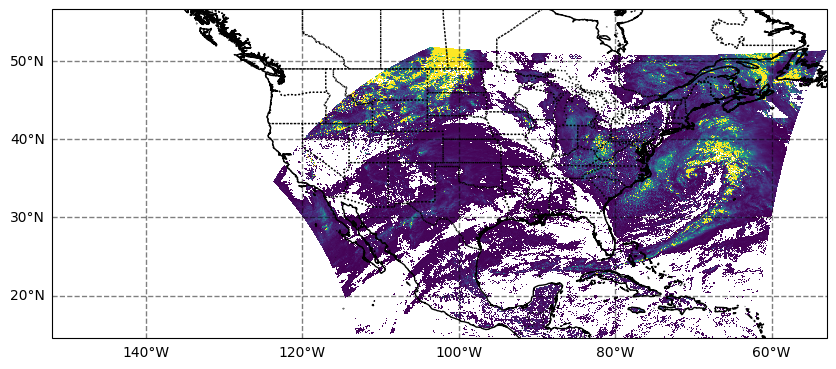

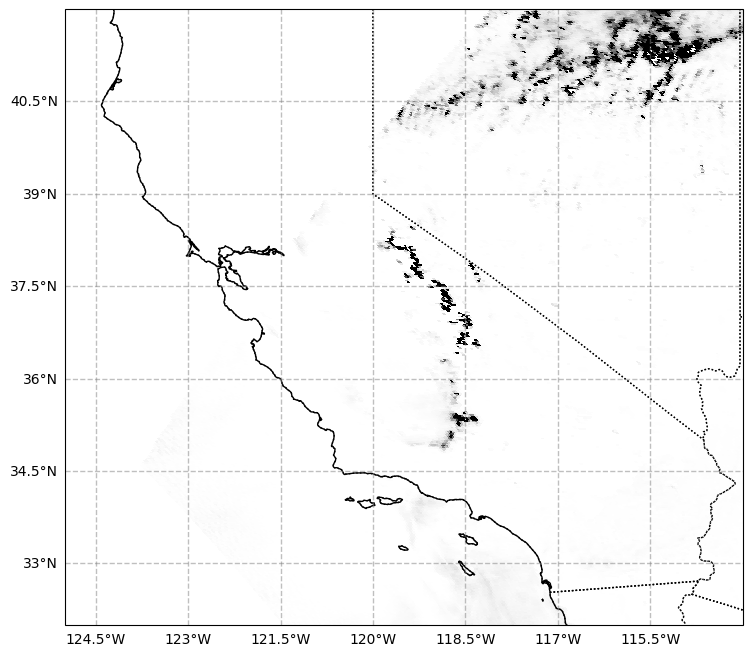

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day92.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day92.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day92.nc


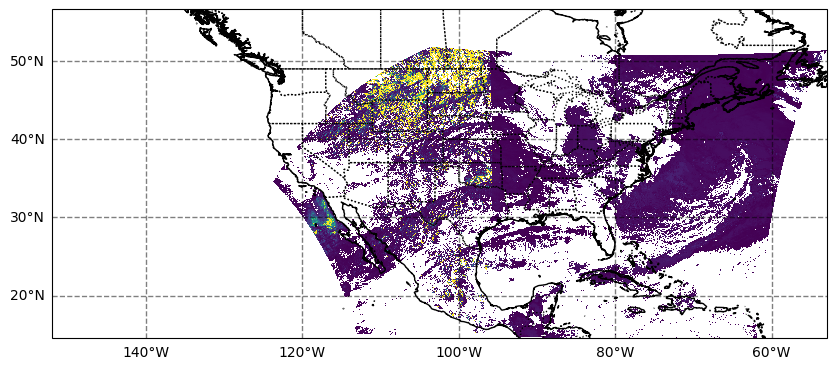

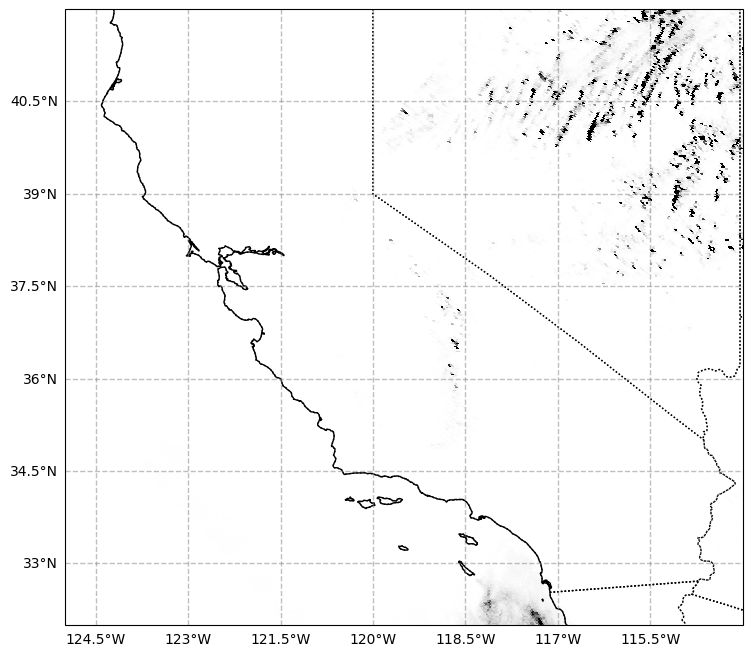

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day93.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day93.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day93.nc


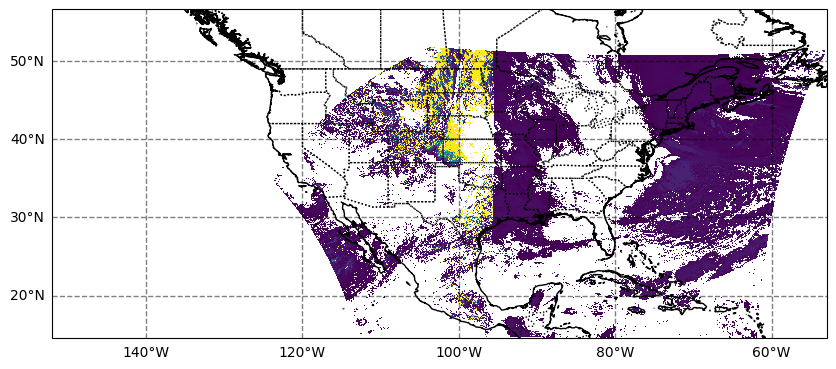

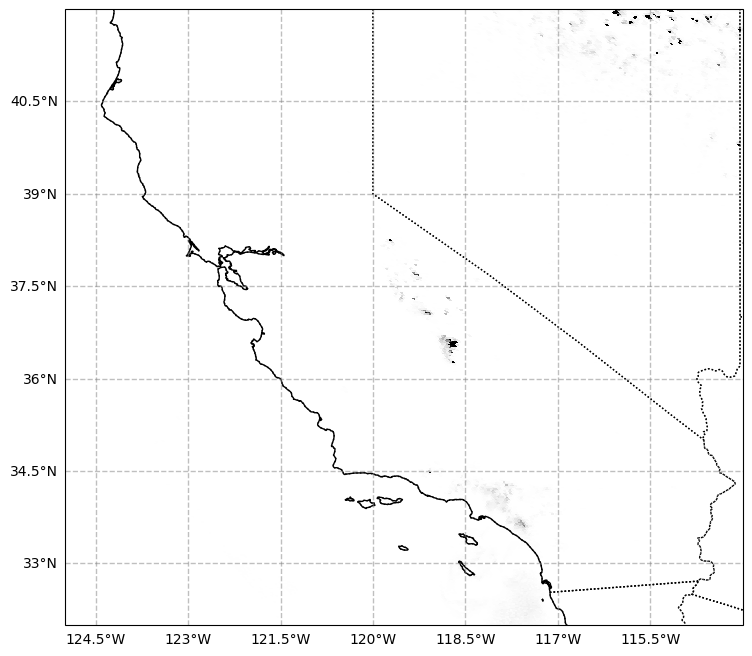

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day94.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day94.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day94.nc


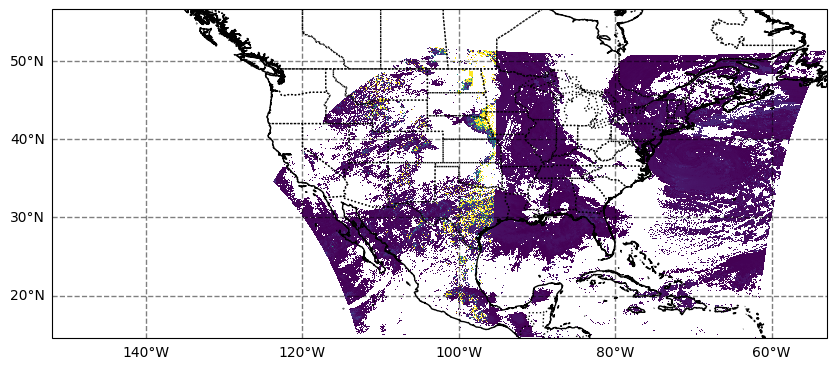

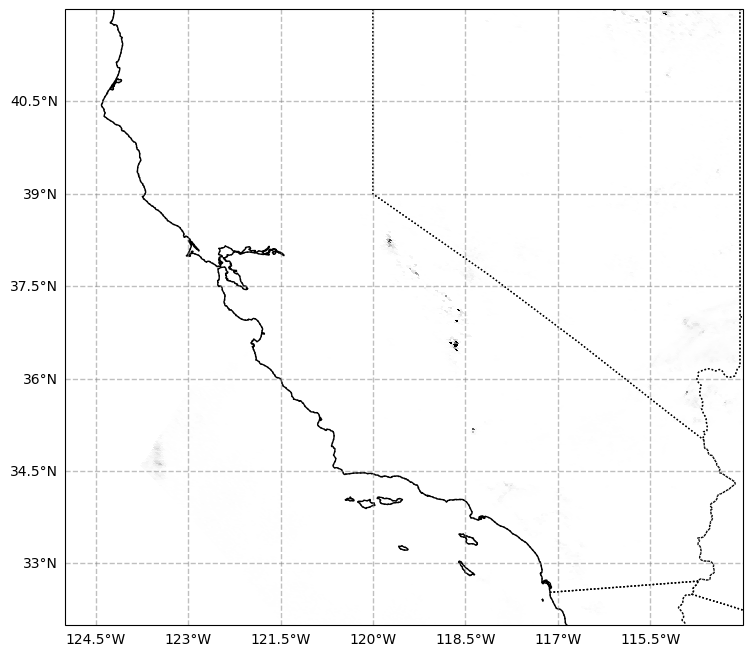

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day95.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day95.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day95.nc


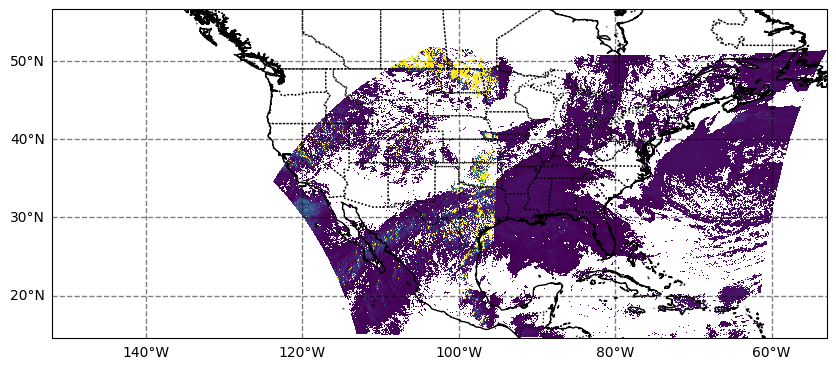

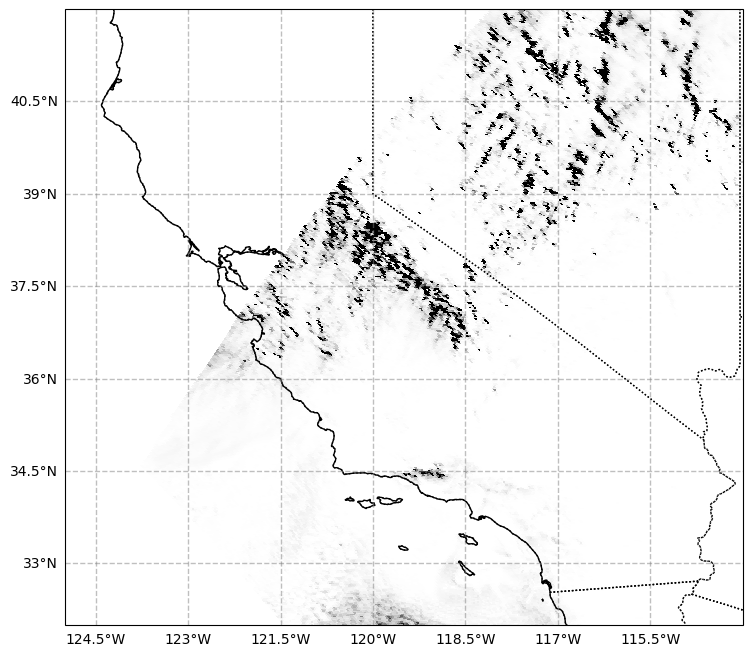

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day96.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day96.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day96.nc


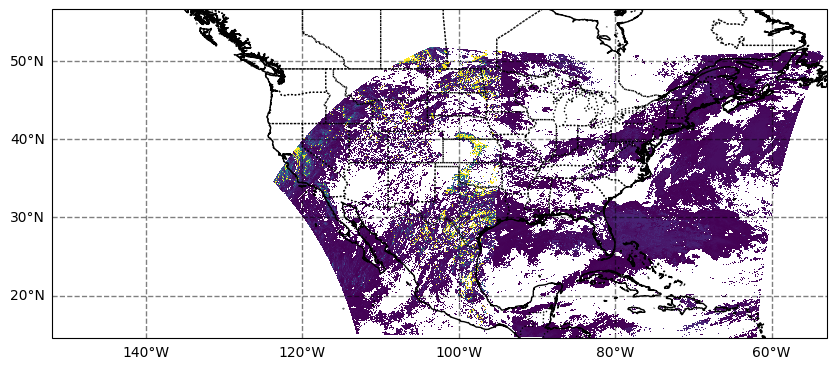

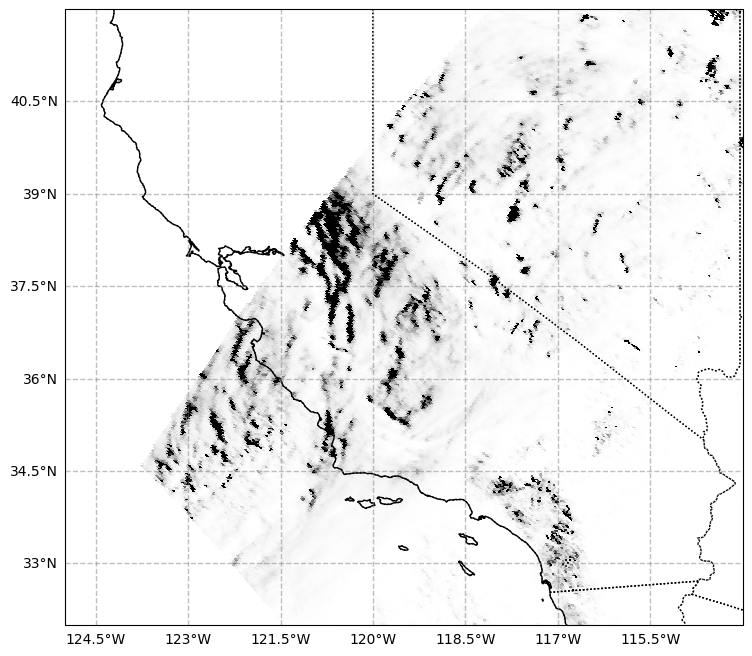

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day97.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day97.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day97.nc


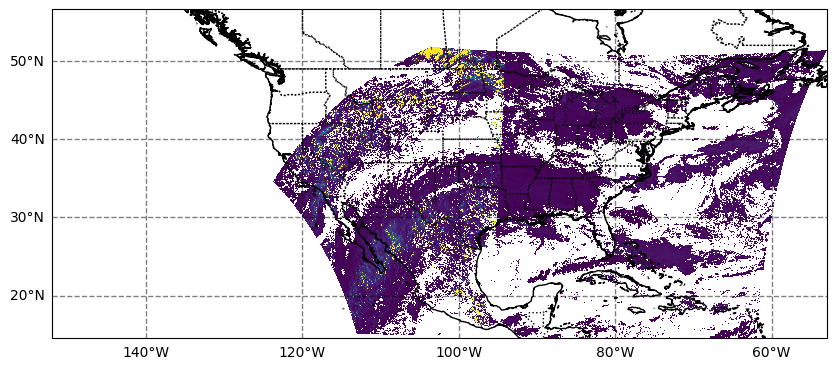

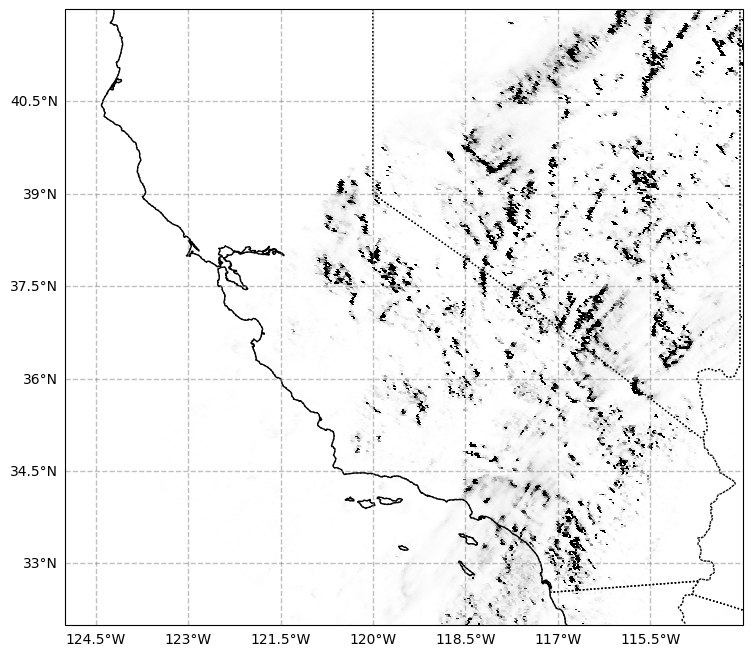

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day98.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day98.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day98.nc


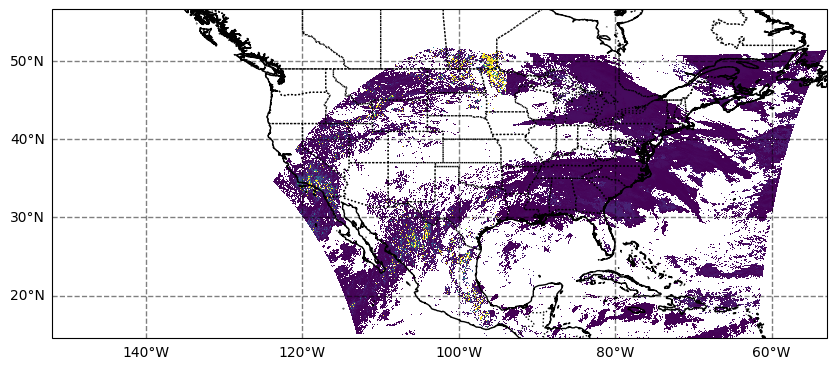

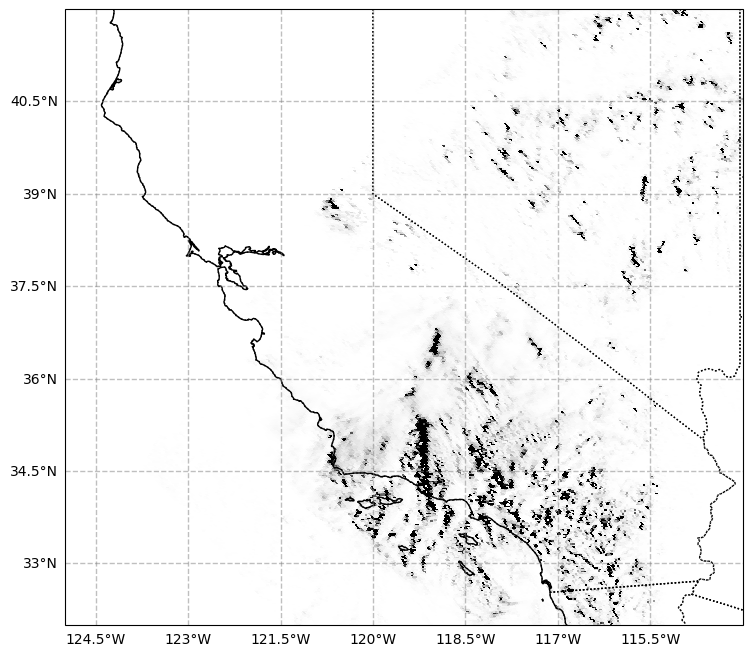

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day99.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day99.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day99.nc


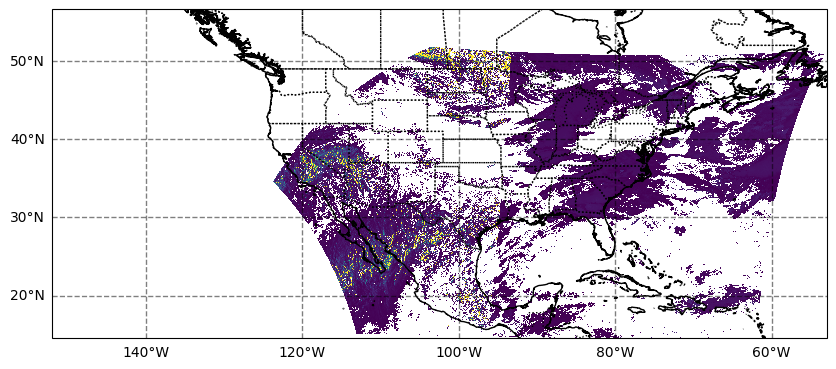

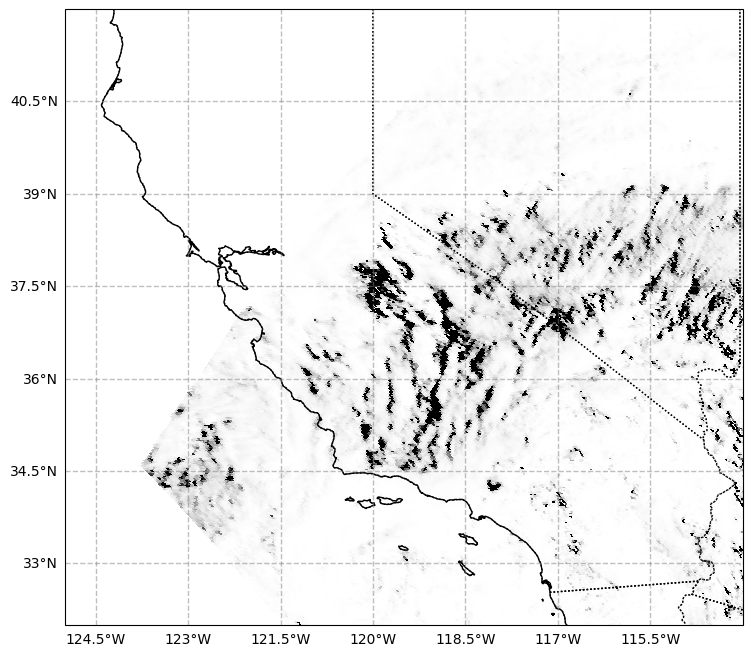

C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudAndMoistureImagery_2022day100.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_ReflectedSW_2022day100.nc
C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day100.nc


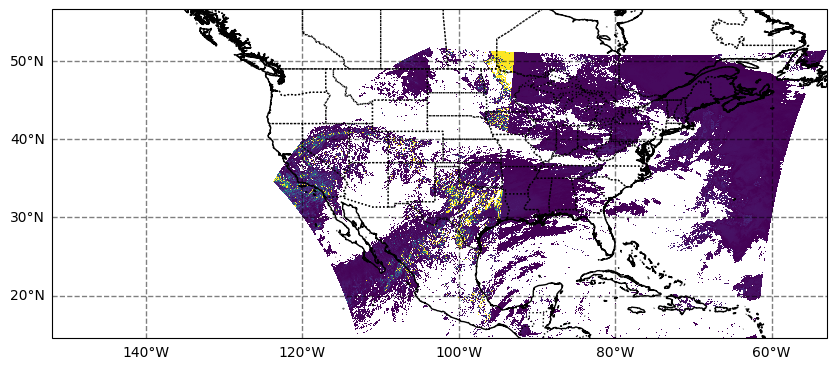

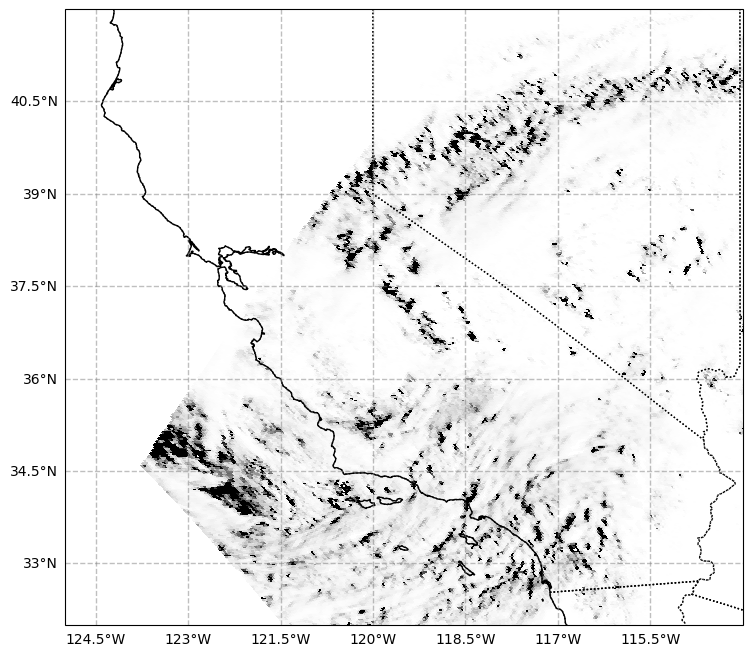

In [14]:
# Process data for Julian day 91
cloudimagery91_lat, cloudimagery91_lon, cloudimagery91_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[0])
reflectedsw91_lat, reflectedsw91_lon, reflectedsw91_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[0])
cloudopticaldepth91_lat, cloudopticaldepth91_lon, cloudopticaldepth91_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[0])

# Process data for Julian day 92
cloudimagery92_lat, cloudimagery92_lon, cloudimagery92_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[1])
reflectedsw92_lat, reflectedsw92_lon, reflectedsw92_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[1])
cloudopticaldepth92_lat, cloudopticaldepth92_lon, cloudopticaldepth92_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[1])

# Process data for Julian day 93
cloudimagery93_lat, cloudimagery93_lon, cloudimagery93_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[2])
reflectedsw93_lat, reflectedsw93_lon, reflectedsw93_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[2])
cloudopticaldepth93_lat, cloudopticaldepth93_lon, cloudopticaldepth93_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[2])

# Process data for Julian day 94
cloudimagery94_lat, cloudimagery94_lon, cloudimagery94_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[3])
reflectedsw94_lat, reflectedsw94_lon, reflectedsw94_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[3])
cloudopticaldepth94_lat, cloudopticaldepth94_lon, cloudopticaldepth94_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[3])

# Process data for Julian day 95
cloudimagery95_lat, cloudimagery95_lon, cloudimagery95_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[4])
reflectedsw95_lat, reflectedsw95_lon, reflectedsw95_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[4])
cloudopticaldepth95_lat, cloudopticaldepth95_lon, cloudopticaldepth95_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[4])

# Process data for Julian day 96
cloudimagery96_lat, cloudimagery96_lon, cloudimagery96_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[5])
reflectedsw96_lat, reflectedsw96_lon, reflectedsw96_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[5])
cloudopticaldepth96_lat, cloudopticaldepth96_lon, cloudopticaldepth96_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[5])

# Process data for Julian day 97
cloudimagery97_lat, cloudimagery97_lon, cloudimagery97_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[6])
reflectedsw97_lat, reflectedsw97_lon, reflectedsw97_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[6])
cloudopticaldepth97_lat, cloudopticaldepth97_lon, cloudopticaldepth97_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[6])

# Process data for Julian day 98
cloudimagery98_lat, cloudimagery98_lon, cloudimagery98_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[7])
reflectedsw98_lat, reflectedsw98_lon, reflectedsw98_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[7])
cloudopticaldepth98_lat, cloudopticaldepth98_lon, cloudopticaldepth98_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[7])

# Process data for Julian day 99
cloudimagery99_lat, cloudimagery99_lon, cloudimagery99_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[8])
reflectedsw99_lat, reflectedsw99_lon, reflectedsw99_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[8])
cloudopticaldepth99_lat, cloudopticaldepth99_lon, cloudopticaldepth99_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[8])

# Process data for Julian day 100
cloudimagery100_lat, cloudimagery100_lon, cloudimagery100_rgb = CloudImageryProcessingFunction(file_array_cloud_and_moisture[9])
reflectedsw100_lat, reflectedsw100_lon, reflectedsw100_rsr = ReflectedSWProcessingFunction(file_array_reflected_sw[9])
cloudopticaldepth100_lat, cloudopticaldepth100_lon, cloudopticaldepth100_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[9])


In [15]:
# Create a dictionary to store all the processed data for Julian days 91 to 100
data_dict = {
    'Julian_day_91': {
        'cloud_imagery': {'lat': cloudimagery91_lat, 'lon': cloudimagery91_lon, 'rgb': cloudimagery91_rgb},
        'reflected_sw': {'lat': reflectedsw91_lat, 'lon': reflectedsw91_lon, 'rsr': reflectedsw91_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth91_lat, 'lon': cloudopticaldepth91_lon, 'cod': cloudopticaldepth91_cod}
    },
    'Julian_day_92': {
        'cloud_imagery': {'lat': cloudimagery92_lat, 'lon': cloudimagery92_lon, 'rgb': cloudimagery92_rgb},
        'reflected_sw': {'lat': reflectedsw92_lat, 'lon': reflectedsw92_lon, 'rsr': reflectedsw92_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth92_lat, 'lon': cloudopticaldepth92_lon, 'cod': cloudopticaldepth92_cod}
    },
    'Julian_day_93': {
        'cloud_imagery': {'lat': cloudimagery93_lat, 'lon': cloudimagery93_lon, 'rgb': cloudimagery93_rgb},
        'reflected_sw': {'lat': reflectedsw93_lat, 'lon': reflectedsw93_lon, 'rsr': reflectedsw93_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth93_lat, 'lon': cloudopticaldepth93_lon, 'cod': cloudopticaldepth93_cod}
    },
    'Julian_day_94': {
        'cloud_imagery': {'lat': cloudimagery94_lat, 'lon': cloudimagery94_lon, 'rgb': cloudimagery94_rgb},
        'reflected_sw': {'lat': reflectedsw94_lat, 'lon': reflectedsw94_lon, 'rsr': reflectedsw94_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth94_lat, 'lon': cloudopticaldepth94_lon, 'cod': cloudopticaldepth94_cod}
    },
    'Julian_day_95': {
        'cloud_imagery': {'lat': cloudimagery95_lat, 'lon': cloudimagery95_lon, 'rgb': cloudimagery95_rgb},
        'reflected_sw': {'lat': reflectedsw95_lat, 'lon': reflectedsw95_lon, 'rsr': reflectedsw95_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth95_lat, 'lon': cloudopticaldepth95_lon, 'cod': cloudopticaldepth95_cod}
    },
    'Julian_day_96': {
        'cloud_imagery': {'lat': cloudimagery96_lat, 'lon': cloudimagery96_lon, 'rgb': cloudimagery96_rgb},
        'reflected_sw': {'lat': reflectedsw96_lat, 'lon': reflectedsw96_lon, 'rsr': reflectedsw96_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth96_lat, 'lon': cloudopticaldepth96_lon, 'cod': cloudopticaldepth96_cod}
    },
    'Julian_day_97': {
        'cloud_imagery': {'lat': cloudimagery97_lat, 'lon': cloudimagery97_lon, 'rgb': cloudimagery97_rgb},
        'reflected_sw': {'lat': reflectedsw97_lat, 'lon': reflectedsw97_lon, 'rsr': reflectedsw97_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth97_lat, 'lon': cloudopticaldepth97_lon, 'cod': cloudopticaldepth97_cod}
    },
    'Julian_day_98': {
        'cloud_imagery': {'lat': cloudimagery98_lat, 'lon': cloudimagery98_lon, 'rgb': cloudimagery98_rgb},
        'reflected_sw': {'lat': reflectedsw98_lat, 'lon': reflectedsw98_lon, 'rsr': reflectedsw98_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth98_lat, 'lon': cloudopticaldepth98_lon, 'cod': cloudopticaldepth98_cod}
    },
    'Julian_day_99': {
        'cloud_imagery': {'lat': cloudimagery99_lat, 'lon': cloudimagery99_lon, 'rgb': cloudimagery99_rgb},
        'reflected_sw': {'lat': reflectedsw99_lat, 'lon': reflectedsw99_lon, 'rsr': reflectedsw99_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth99_lat, 'lon': cloudopticaldepth99_lon, 'cod': cloudopticaldepth99_cod}
    },
    'Julian_day_100': {
        'cloud_imagery': {'lat': cloudimagery100_lat, 'lon': cloudimagery100_lon, 'rgb': cloudimagery100_rgb},
        'reflected_sw': {'lat': reflectedsw100_lat, 'lon': reflectedsw100_lon, 'rsr': reflectedsw100_rsr},
        'cloud_optical_depth': {'lat': cloudopticaldepth100_lat, 'lon': cloudopticaldepth100_lon, 'cod': cloudopticaldepth100_cod}
    }
}


In [16]:
import pickle
# Save the dictionary to a file using pickle
file_path = 'C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/cleaned_data.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(data_dict, f)

# Confirm file saved
print(f"Data dictionary saved to {file_path}")

Data dictionary saved to C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/cleaned_data.pkl


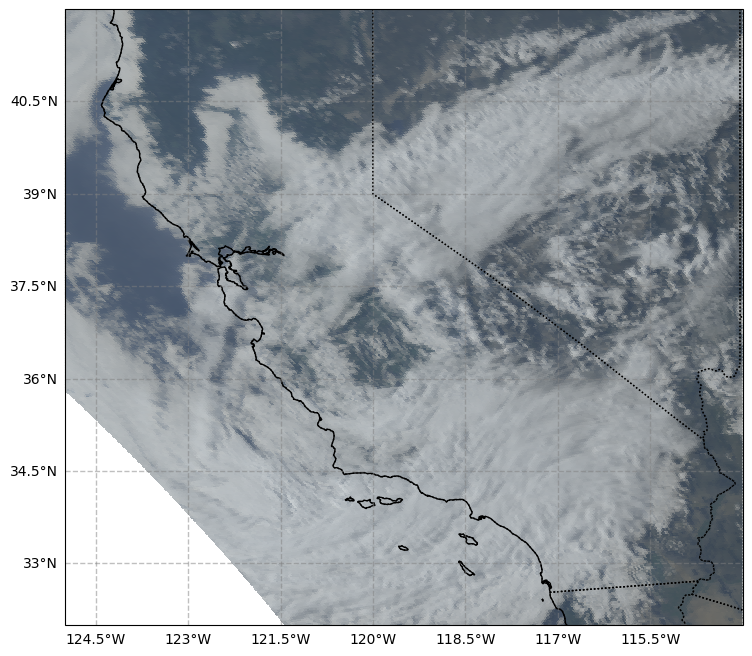

In [17]:
# Create the plot using cartopy
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(cloudimagery100_lon, cloudimagery100_lat, cloudimagery100_rgb, transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()

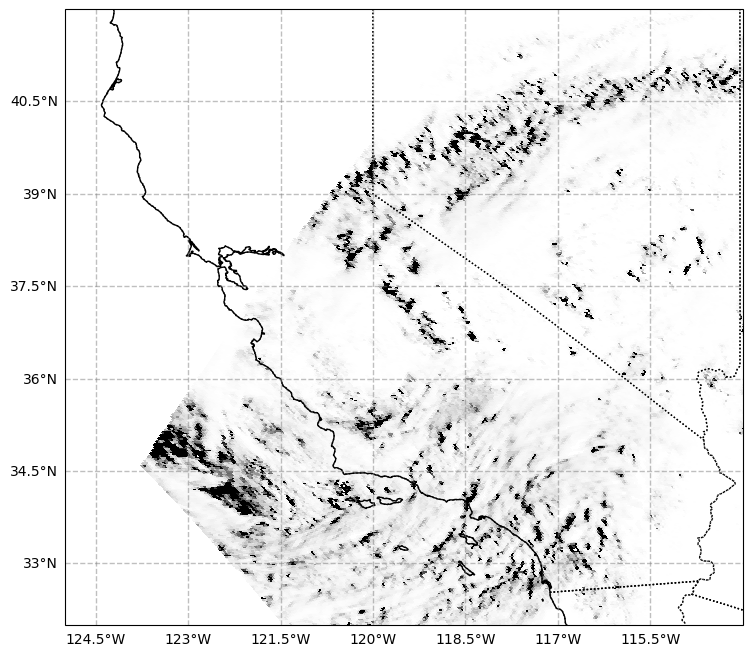

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(cloudopticaldepth100_lon, cloudopticaldepth100_lat, cloudopticaldepth100_cod, transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()


C:/Users/adhal/OneDrive/Season3/Fall2024/MachineLearning/Data/GOESCloudMoistureImagery/GOES16_CloudOpticalDepth_2022day100.nc


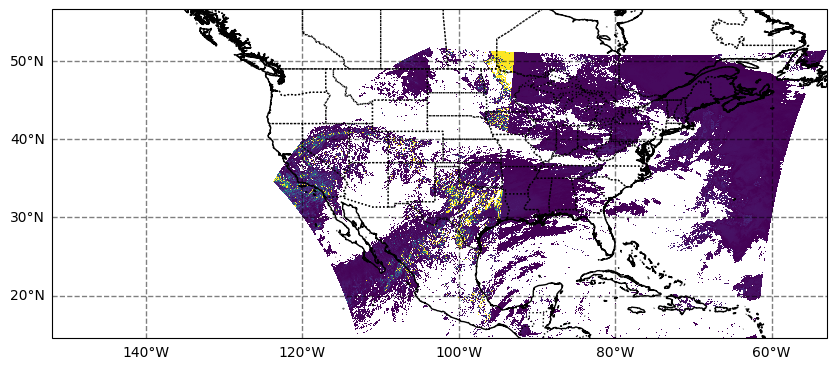

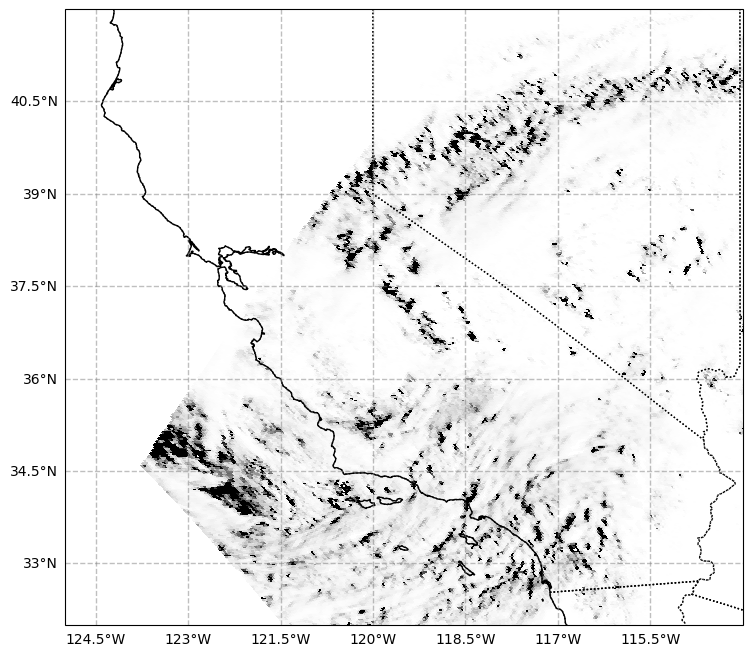

In [19]:
cloudopticaldepth100_lat, cloudopticaldepth100_lon, cloudopticaldepth100_cod = CloudOpticalDepthProcessingFunction(file_array_cloud_optical_depth[9])


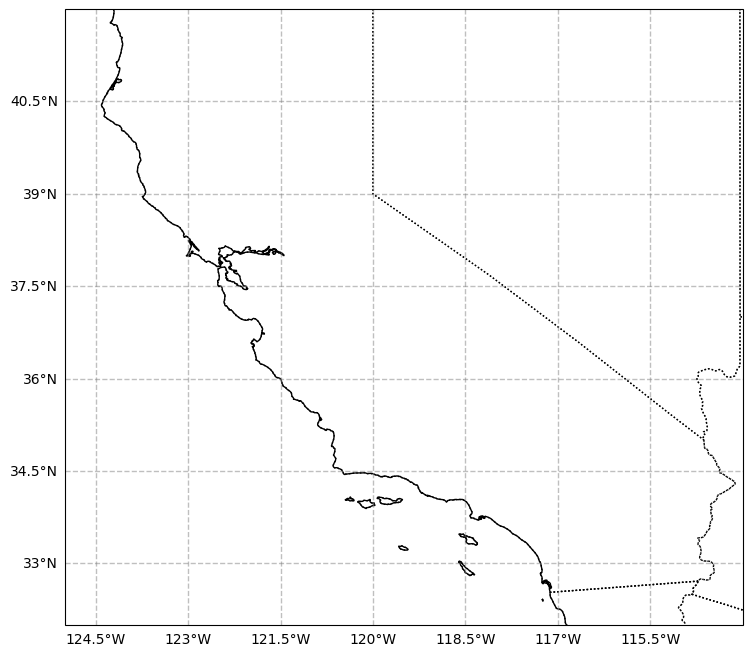

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-125, -114, 32, 42], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(cloudopticaldepth100_lat, cloudopticaldepth100_lon, cloudopticaldepth100_cod, transform=ccrs.PlateCarree(), cmap='Greys', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()
